# 15.774/15.780 Fall 2023
## The Analytics of Operations Management
### Problem Set 2 - Logistic Regression & Data Cleaning
#### Due Date:  10/06
---
Name of Student: [Joy Bhattacharya]

MIT ID Number: [922631264]

---

### Instructions:

1) Submit solutions that are your own, in your own words. You are allowed to discuss with other students in general terms, but make sure you are not copying verbatim from another student. Therefore do not read other students' solutions. If you use material from outside this class, reference it in your solution. 

2) Please download the python file attached in the assignment and complete your answers there in the same file. Read the questions carefully, and make sure you answer every part that the question asks.

3) Include relevant code in the PDF submission even if the question doesn't explicitly ask for it. Upload your solutions as a PDF file. Include your name and MIT ID on the first page.

4) To convert to pdf, you can use the "print to pdf" option in jupyter (or equivalent options in other IDE). There are other options to directly download in to pdf format which might include additional installation of packages. 

5) Show your work and explain your conclusions clearly and precisely. Plots should have clear titles and axis labels so that it is clear what your analysis is showing.

--------------------------------------------------------------------------------------------------------------------------------

First, we import the packages we will be using

In [1]:
# Install the packages you do not have
# !pip install sklearn

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
np.float=float
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\joyse\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


---
## $\textbf{Problem 1.}$ (Logistic Regression) (40 pts)

Historically, lending money to individuals has been done by banks, credit unions, and savings and loan associations. There has been a recent uptick in what is known as peer-to-peer lending, where one individual loans money to another (2015 market share of $\$26.2$ billion). We have data from LendingClub.com, the world’s largest peer-to-peer lending platform, which issued $\$13.4$ billion in loans from its founding in 2006 through October 2015. 

Our data is a subset of these loans: 
  * 9,516 3-year loans funded by them between May 2007 and February 2010.
  * We have information on whether the loan was not paid in full (**1 if not paid in full, zero otherwise**).
  * We also have 6 covariates available at the time the loan was granted, including Monthly loan installment, log annual income, FICO score, revolving balance on credit cards, number of credit inquiries over the past six months, and number of deleterious public records.
  * These represent just a tiny portion of the covariates LendingClub.com would actually have access to when making a loan decision. Using this data, stored in the data set loans.csv,

We will try to **build a model for correctly predicting the probability that an individual defaults on the loan**.


In [3]:
# Assuming 'loans.csv' is in the same directory as your Python script or Jupyter Notebook
file_path = "loans.csv"

# Use the read_csv function to load the CSV file into a DataFrame
loans = pd.read_csv(file_path)
loans.head()

,not_fully_paid,installment,log_annual_inc,fico,revol_bal,inq_last_6mths,pub_rec,is_training_data
0,0,829.10,4.929419,737,28.854,0,0,True
1,0,228.22,4.812913,707,33.623,0,0,False
2,0,366.86,4.505150,682,3.511,1,0,False
3,0,162.34,4.929419,712,33.667,1,0,True
4,0,102.92,4.907411,667,4.740,0,0,True


In [4]:
# Use the column 'is_training_data' to split the set into training and test data (True is training and False is test)
loans_train = loans[loans['is_training_data'] == True]
loans_test = loans[loans['is_training_data'] == False]

# Delete the column 'is_training_data' as we do not want it to be part of the model (is not an actual feature of loans)
del loans_train['is_training_data']
del loans_test['is_training_data']

print("Train set shape:", loans_train.shape)
print("Test set shape:", loans_test.shape)

Train set shape: (6661, 7)
Test set shape: (2855, 7)


**1**. Run a simple logistic regression of `not_fully_paid` on `fico`, on your training data. Write down an equation that gives the estimated conditional probability of defaulting, given a FICO score x, and use it to predict the probability of defaulting for individuals with a FICO score of 700 and 650, respectively. Do this two ways: one by directly plugging in values to your equation, and another by using the `predict` function of your model. Report and comment your results. **(10 pts)**


***
We first train our model

In [5]:
# Define the dependent variable (y) and predictor variable (X)
y_train_11 = loans_train["not_fully_paid"]
X_train_11 = loans_train["fico"]

# Add a constant term to the predictor variable (intercept)
X_train_11 = sm.add_constant(X_train_11)

# Fit the linear regression model
log_reg_11 = sm.Logit(y_train_11, X_train_11).fit()

# Get the model summary
summary = log_reg_11.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.425939
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 6661
Model:                          Logit   Df Residuals:                     6659
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                 0.03081
Time:                        14:06:12   Log-Likelihood:                -2837.2
converged:                       True   LL-Null:                       -2927.4
Covariance Type:            nonrobust   LLR p-value:                 3.948e-41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3642      0.702     10.496      0.000       5.989       8.739
fico          -0.0128      0.

***
Probability of default (first approach: manual equation)


In [6]:
# Get the 'fico' and 'intercept' coefficients
fico_coeff = log_reg_11.params["fico"]
intercept_coeff = log_reg_11.params["const"]

# Define your equation as a lambda function so that we can reuse it
default_prob_equation = lambda x: np.exp(intercept_coeff + fico_coeff * x) / (1 + np.exp(intercept_coeff + fico_coeff * x))


# Evaluate the expression for a FICO score of 700 and report the value
p_700 = default_prob_equation(700)
p_700

0.16848836377007184

In [7]:
# Evaluate the expression for a FICO score of 650 and report the value
p_650 = default_prob_equation(650)
p_650

0.2776120401174487

***
Probability of default (second approach: model's prediction)

In [8]:
# Prepare the test set with the 2 values 700 and 650  (Hint: Define it as a pandas DataFrame)
X_test_11 = pd.DataFrame({"fico": [700,650]})

# Add a constant term to the predictor variable (intercept)
X_test_11 = sm.add_constant(X_test_11)

# Predict the probabilities of default and report those values
probs_11 = log_reg_11.predict(X_test_11)
probs_11

0    0.168488
1    0.277612
dtype: float64

**Comments:** Both methods predict the same thing. The p-value of the fico score is less than 0.05, which means it is statistically significant and should be included in the model because it's a good predictor. The coefficient on the fico score is -0.0128, indicating that there is a negative relationship between fico credit score and the probability of defaulting (the higher your credit score, the lower your probability of defaulting). With our logistic model, a person with a fico score of 700, holding all else constant, is predicted to have a 0.1684 probability of defaulting. A person with a 650 fico score has an expected probability of 0.277 of defaulting holding all else constant. This makes sense because we would expect someone with a lower credit score to be more likely to default since credit scores are lower the less trustworthy you are.

---
**2**. Construct a multiple logistic regression model that predicts `not_fully_paid` as a function of all of the covariates in the data set. Based on this multiple regression model, is there evidence that including `fico` in the model improved performance over a model including every variable except for `fico`? **(10 pts)**

In [9]:
# Define the features of the model
features_12 = ["installment", "log_annual_inc", "fico", "revol_bal", "inq_last_6mths", "pub_rec"]

# Define the dependent variable (y) and predictor variable (X)
y_train_12 = loans_train["not_fully_paid"]
X_train_12 = loans_train[features_12]

# Add a constant term to the predictor variable (intercept)
X_train_12 = sm.add_constant(X_train_12)

# Fit the linear regression model
log_reg_12 = sm.Logit(y_train_12, X_train_12).fit()

# Get the model summary
summary = log_reg_12.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.413768
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 6661
Model:                          Logit   Df Residuals:                     6654
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                 0.05851
Time:                        14:06:25   Log-Likelihood:                -2756.1
converged:                       True   LL-Null:                       -2927.4
Covariance Type:            nonrobust   LLR p-value:                 6.145e-71
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.0152      0.992     10.098      0.000       8.071      11.959
installment      

In [10]:
# Zoom-in on the actual p-values
log_reg_12.pvalues
# FILL IN

const             5.615125e-24
installment       1.276738e-09
log_annual_inc    1.069739e-09
fico              4.392585e-26
revol_bal         2.385457e-06
inq_last_6mths    6.447360e-22
pub_rec           6.291805e-02
dtype: float64

**Comment**: Based on this multiple regression model, there is evidence that including fico in the model improved our performance over a model including every variable except for fico. This is because when we include fico in the multi-feature model, the p-value of fico is extremely small, much less than 0.05. This means that it is statistically significant and should be included in the model and therefore improves the model. 

---



**3.** A highly simplified analysis leads LendingClub.com to the following conclusion: If an individual defaults on their loan and can’t pay it back, we incur a profit of $-\$4000$ (i.e. a loss of $\$4000$). If the individual does not default, we realize a profit of $\$1000$. 

Based on this, for what estimated values of probability for default should I not give the individual a loan in the first place (hence guaranteeing an expected profit of $0)? Note: You do not have to write code for this question. Explain your computations in the answer cell **(10 pts)**

**Answer:** Let p_d be the probaility of default. LendingClub.com's expected profit is as follows and they only want to lend when their expected profit is above 0: p_d(-4000)+(1-p_d)(1000)>0. This equation is satisfied for p_d<1/5. So, we would NOT want to give the individual a loan in the first place if p_d>1/5. So, if they have a probability of default greater than 0.2 we wouldn't want to give them a loan because then our expected profit would be negative. 

*** 
**4.** For the multiple logistic regression model, use this break-even probability as a threshold to classify whether or not an individual would default (that is, you will predict “Default” if someone is predicted above your probability in part **1.3** and “No Default” otherwise). Based on this rule, report the confusion matrix of your predicted outcome and the actual outcome with respect to the **test set**. After doing so,
provide the following summary measures of performance: 
* Accuracy
* Sensitivity (True Positive Rate)
* Specificity (True Negative Rate)
**(10 pts)**

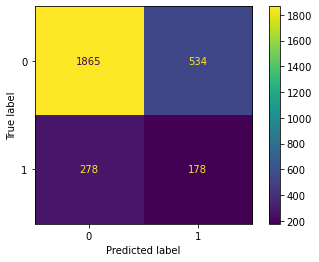

In [11]:
# Define the dependent variable (y) and predictor variable (X) (Hint: same features as in 1.2)
y_test_14 = loans_test["not_fully_paid"]
X_test_14 = loans_test[features_12]

# Add a constant term to the predictor variable (intercept)
X_test_14 = sm.add_constant(X_test_14)

# Predict default probabilities with the model 
default_probs_14 = log_reg_12.predict(X_test_14)

# Use the probability of 1.3 to transform the probabilities into 0-1 predictions
default_preds_14 = (default_probs_14 > 0.2)

# Compute and show the confusion matrix
cm_14 = confusion_matrix(y_test_14, default_preds_14)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_14)
disp.plot()
plt.show()

In [12]:
# Compute and report all the metrics 
TN, FP = 1865, 534
FN, TP = 278, 178

ACC = (TN + TP) / (TN + FN + TP +FP) 
print(f"Accuracy: {ACC:.3f}")

TPR = TP / (TP + FN)  
print(f"Sensitivity (True Positive Rate): {TPR:.3f}")

TNR = TN / (TN + FP) 
print(f"Specificity (True Negative Rate): {TNR:.3f}")

Accuracy: 0.716
Sensitivity (True Positive Rate): 0.390
Specificity (True Negative Rate): 0.777


---
---
## $\textbf{Problem 2.}$ (Data Cleaning) (40 pts)

In this problem, we will explore Outliers Removal and Missing Data Imputation techniques. The problem is based on the Boston Housing dataset. A brief description of the dataset is the following:

*This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It was obtained from the StatLib archive (http://lib.stat.cmu.edu/datasets/boston), and has been used extensively throughout the literature to benchmark algorithms. However, these comparisons were primarily done outside of Delve and are thus somewhat suspect. The dataset is small in size with only 506 cases.*

For additional information, please visit this [Link](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html#:~:text=The%20Boston%20Housing%20Dataset,the%20area%20of%20Boston%20Mass.)

We first load the data.

In [13]:
# Assuming 'housing.csv' is in the same directory as your Python script or Jupyter Notebook
file_path = "housing.csv"

# Use the read_csv function to load the CSV file into a DataFrame
housing = pd.read_csv(file_path)
housing.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


**1**. There are two rows that contain outlier values for the variable `age`. Use a box plot to detect them and report their values. Explain why those values are incorrect and eliminate those rows from the dataset. Briefly comment on what could be the source of error and suggest a quick fix (*Note: You do not have to implement the fix, you already removed those rows*) **(10 pts)**


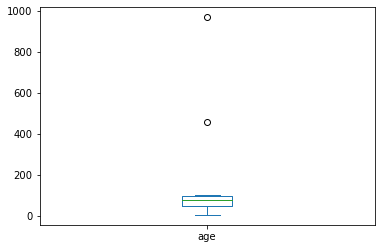

In [14]:
# Use a box plot to detect the outliers
housing.age.plot.box()

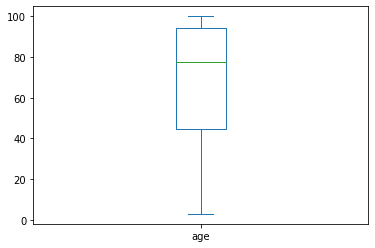

In [15]:
# Remove those points
housing = housing[housing["age"] <= 100]

# Use a box plot again after removing the outliers to check the removal

housing.age.plot.box()

**Comment:** The outlier values from the boxplot are at around 480 and 980. Those values are incorrect because age is a proportion, meaning it should be under 100 after it is converted to percent form (which presumably it is in this dataset). So we know that any age value above 100 is incorrect. I'm assuming that the reason those are incorrect is some form of human error. Maybe those values were typed in correctly (an extra 0 was added, numbers were flipped, etc). One way to quickly fix this is to see if there is a pattern in the errors (maybe a 0 was added to the end and we can just delete that). If we could find a pattern, we could try to correct those data values. If not, we should just delete them as we do later on. 

---
**Checkpoint** To make sure you have removed the rows, run the following code before continuing the next sections. If you get errors, you have not removed them correctly. It should run without printing any error. (This part is not graduated).


In [16]:
assert len(housing) == 504
assert housing.age.mean().round() == 69

***
**2.** Find all the variables that contain any missing values. For each of them report the percentage of missing values. **(5 pts)**

In [17]:
# Compute the percentage of missing values for each variable
nan_perc = housing.isna().mean()

# Filter those that contain nans
nan_perc = nan_perc[nan_perc > 0]

nan_perc

crim    0.037698
dtype: float64

**Comment:** 3.7698% of the crim values are missing in the dataset. 

---
**3.** Impute `crim` values using the **mean** and the **median**. For that follow these steps:
* Randomly split the data into training ($80\%$ of rows.) and test ($20\%$ of rows). Code is provided for this step, please do not change the seed or the split percentage.
* Compute the **mean** and **median** `crim` values in the training. We will use this value for the test set.
* Report the MAPE of these imputations in the test set. Which model is more accurate? **(10 pts)**

In [18]:
# MAPE function
def compute_mape(y_true, y_pred):
    return (100 * abs((y_true - y_pred) / y_true)).mean()

In [22]:
# Keep first only the data that has values for crim
housing_no_nas = housing[~housing.crim.isna()]

# Split your data in 80% train and 20% test (do not modify the seed or the split percentage)
np.random.seed(15774)
housing_no_nas_train, housing_no_nas_test = train_test_split(housing_no_nas, train_size=0.8)

# Build X and y for test and train
features_22 = ['crim']
X_train_22 = housing_no_nas_train[features_22]
y_train_22 = housing_no_nas_train['crim']
X_test_22 = housing_no_nas_test[features_22]
y_test_22 = housing_no_nas_test['crim']

# Compute the mean crim in the train set
mean_crim_train = X_train_22.crim.mean()

# Compute and report the MAPE
compute_mape(y_test_22, mean_crim_train, )

3429.341631880411

In [23]:
# Compute the median crim in the train set
median_crim_train = X_train_22.crim.median()

# Compute and report the MAPE
compute_mape(y_test_22, median_crim_train, )

208.7671207960982

**Comment**: The MAPE of the mean model is 3429.34. The MAPE of the median model is 208.767. This means that the median model is more accurate because it has a much lower MAPE, meaning that our predictions on average are 208% percent off from the actual values (whereas our predictions are 3429% off in the mean model). 

---
**4.** Impute `crim` values using a **knn** model with 3 and 5 neighbors. For that follow these steps:
* We will use the random train-test split we computed in 2.3. No need to copy it again, simply use the same sets `housing_no_nas_train` and `housing_no_nas_test`.
* The set of predictors is all the variables except from `crim`
* Train a `KNeighborsRegressor` with 3 neighbors with the training data
* Report the MAPE of these imputations in the test set
* Repeat last two steps with a `KNeighborsRegressor` with 5 neighbors
* Which model is better? Are they better than the previous models?  **(15 pts)**

In [24]:
# Build X and y for test and train
features_23 = ["zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "b", "lstat", "medv"]
X_train_23 = housing_no_nas_train[features_23]
y_train_23 = housing_no_nas_train['crim']
X_test_23 = housing_no_nas_test[features_23]
y_test_23 = housing_no_nas_test['crim']

# Define knn model with 3 neighbors and train it with the train data
knn_3 = KNeighborsRegressor(n_neighbors=3)
knn_3.fit(X_train_23, y_train_23)

# Predict crim
pred_3 = knn_3.predict(X_test_23)

# Compute and report MAPE
compute_mape(y_test_23, pred_3)


64.33771503216866

In [25]:
# Define knn model with 3 neighbors and train it with the train data (Hint: train and test data is the same as in the 2.2)
knn_5 = KNeighborsRegressor(n_neighbors=5)
knn_5.fit(X_train_23, y_train_23)

# Predict crim
pred_5 = knn_5.predict(X_test_23)

# Compute and report MAPE
compute_mape(y_test_23, pred_5)


98.45104609024625

**Comment**: The MAPE of the knn_3 model is 64.337. The MAPE of the knn_5 model is 98.45. Both of these models are better than our previous mean and median models because they both have smaller MAPEs. The best model is the knn_3 model because it has the smallest MAPE, meaning that on average the difference between our predictions and actual values is the smallest in the knn_3 model. 

---
*End of Homework 2*